# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import colors
import sdf
import re
import imageio as imageio
import glob

plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (10, 8)


# Parameters

## Physical Constants

In [2]:
m = 9.10938356e-31
e = 1.60217662e-19
c = 299792458
PI = np.pi
epsilon = 8.85e-12

## Constants From Simulation

In [3]:
DATA_DIR = "long_run_2"
with open (os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
    data=myfile.read()

The parameters which we want to extract are:
* Wavelength: `lambda`
* Laser Time: `las_time`
* Vector Potential: `a0`
* The density factor: `factor`
* Number of Cells: `nx`
* Simulation End Time: `t_end`
* Size of Box: `x_min`
* dt: `dt_snapshot`

In [4]:
def find_value(info):
    regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
    match = regex.search(data)
    if match:
        return float(match.group(1))
    else:
        return None

In [5]:
LAMBD= find_value("lambda0")*1e-6
LAS_TIME = int(find_value("las_time"))
T_MAX = int(find_value("t_end"))
DT = find_value("dt_snapshot")*1e-15
A0 = find_value("a0")
FACTOR = int(find_value("factor"))
NX = int(find_value("nx"))
X_MIN = -int(find_value("x_min"))

print("Values from input.deck:")
print("lambda0 = ", LAMBD)
print("laser_time = ", LAS_TIME)
print("t_end = ", T_MAX)
print("dt_snapshot = ", DT)
print("a0 = ", A0)
print("factor = ", FACTOR)
print("nx = ", NX)
print("x_min = ", X_MIN)

Values from input.deck:
lambda0 =  1e-06
laser_time =  20
t_end =  100
dt_snapshot =  6e-17
a0 =  0.5
factor =  7
nx =  40000
x_min =  -20


## Calculated Constants

In [6]:
omega0 = 2*PI*c/LAMBD
tau = 2*PI/omega0
nc = epsilon*m*omega0**2/e**2
Er = m * omega0 * c / e
n0 = FACTOR*nc

print("Calculated Values for the simulation are:")
print("omega0 = ", omega0)
print("tau = ", tau)
print("nc = ", nc)
print("Er = ", Er)
print("n0 = ", n0)

Calculated Values for the simulation are:
omega0 =  1883651567308853.2
tau =  3.3356409519815205e-15
nc =  1.1143269197457677e+27
Er =  3210701072782.3525
n0 =  7.800288438220374e+27


## Values for FT

In [7]:
omega_to_resolve = 20*omega0
f_max_to_resolve = omega_to_resolve/(2*PI)
dt_max_to_resolve = 1/(2*f_max_to_resolve)
print(f"The maximum time step for resolution is {dt_max_to_resolve*1e15} femto seconds")

The maximum time step for resolution is 0.08339102379953801 femto seconds


In [8]:
f_max = 1/(DT)
omega_max = 2*np.pi*f_max
omega_max/omega0

55.59401586635867

## Other Variables

In [9]:
ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
ALL_FILES.sort()
len(ALL_FILES)

5561

In [10]:
NX

40000

In [11]:
X = np.linspace(X_MIN, -X_MIN, NX)
T = np.linspace(0, T_MAX, len(ALL_FILES))

# Plots

## General

In [12]:
def get_field(id, component="y"):
    raw_data = sdf.read(ALL_FILES[id])
    comp = {
        # "x": raw_data.Electric_Field_Ex,
        "y": raw_data.Electric_Field_Ey,
        # "z": raw_data.Electric_Field_Ez,
    }
    field = comp[component].data
    return field


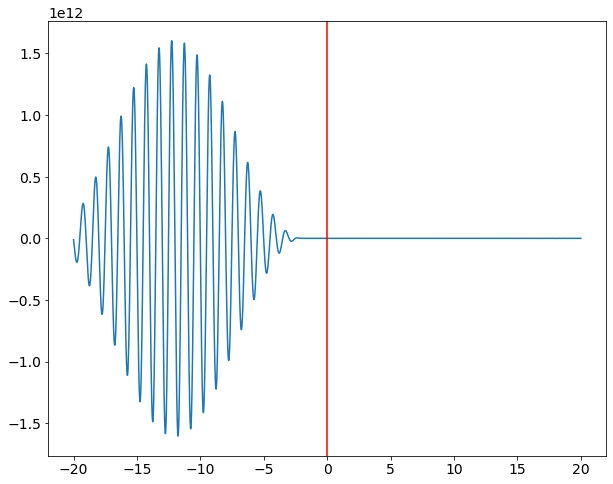

In [13]:
Ey = get_field(1000)
plt.plot(X, Ey)
plt.axvline(0, color="red")
plt.show()


In [14]:
d = np.zeros((len(ALL_FILES), NX))
for i in range(len(ALL_FILES)):
    data = sdf.read(ALL_FILES[i])
    d[i] = data.Derived_Number_Density_Electron.data

In [15]:
d.shape

(5561, 40000)

## Oscillation With Time

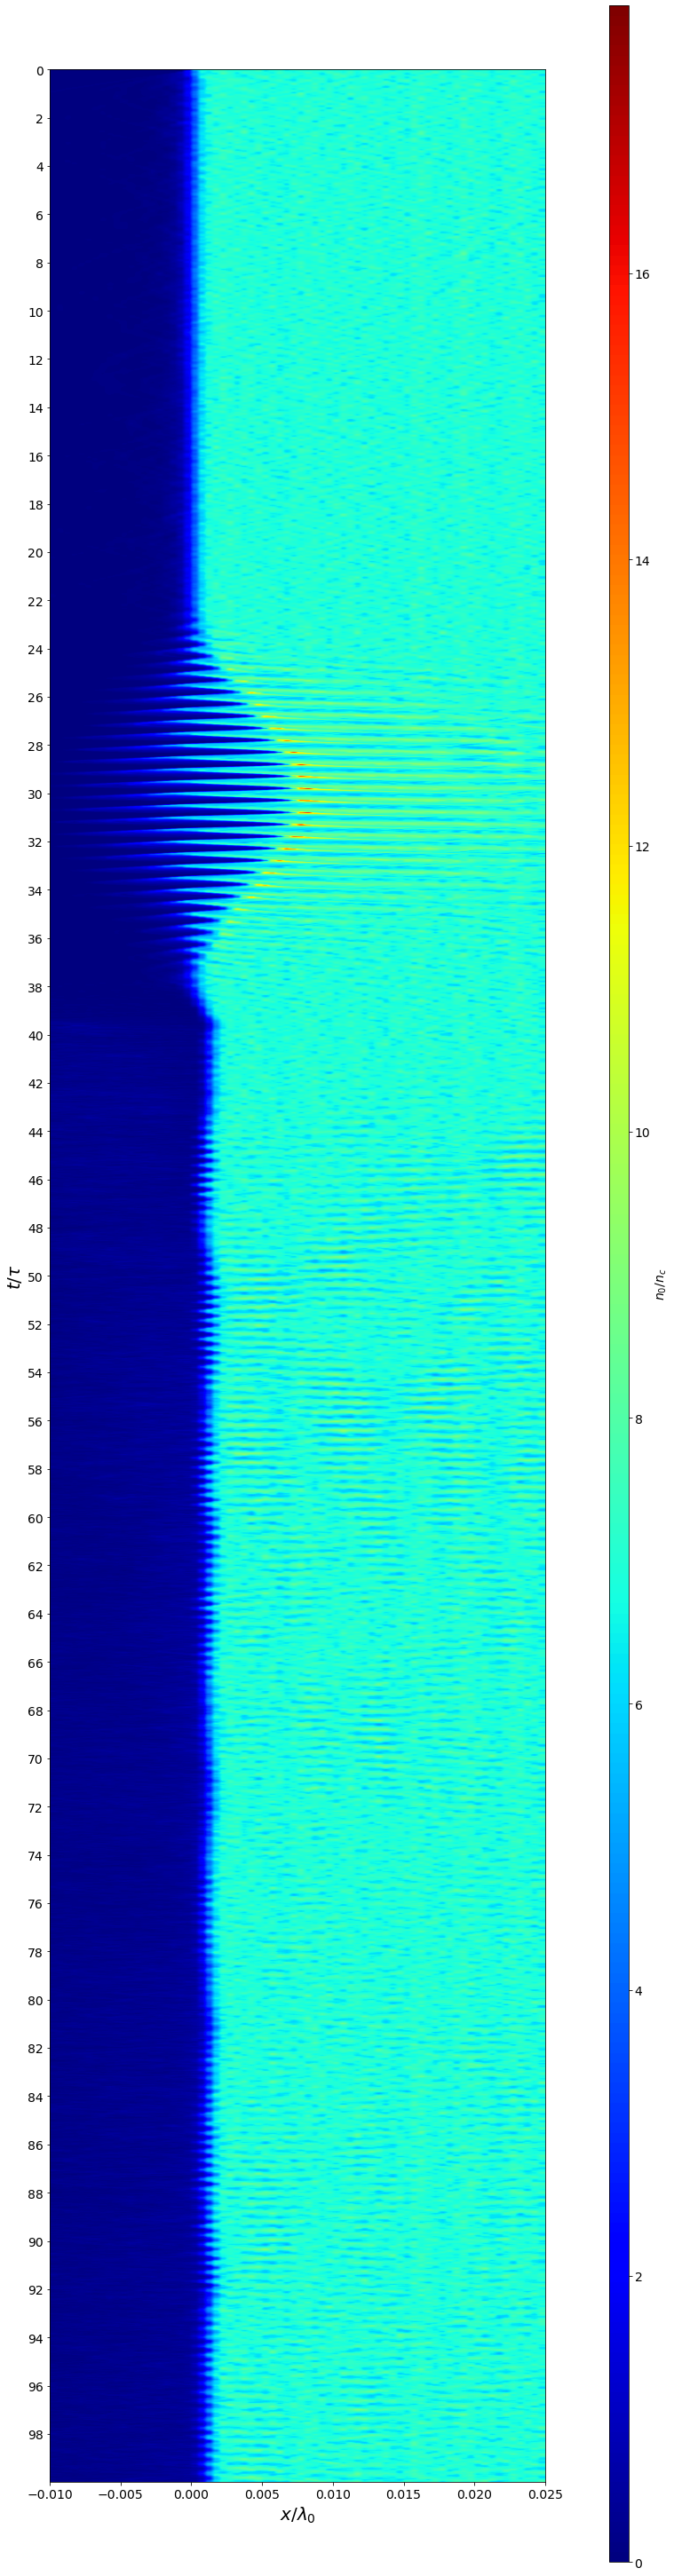

In [16]:
t_start = 0
t_end = len(ALL_FILES)
t_max = d.shape[0]
x_max = d.shape[1]
x_start = 19980
x_end = 20050
EXTENT = [-X_MIN*(x_start-NX//2)/x_max,-X_MIN*(x_end-NX//2)/x_max,T_MAX*t_end/t_max,T_MAX*t_start/t_max]
fig, ax = plt.subplots(figsize=(10, 50))
fig_ = ax.imshow(d[t_start:t_end, x_start:x_end]/nc, extent=EXTENT, cmap="jet", aspect="auto")
cax = fig.add_axes([1.0, 0.1, 0.03, 0.8])
ax.set_yticks(np.arange(0,T_MAX,2))
fig.colorbar(ax.images[0], cax=cax, label=r"$n_0/n_c$", orientation="vertical")
ax.set_xlabel(r"$x/\lambda_0$", fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 20})
ax.set_ylabel(r"$t/\tau$", fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 20});

## The Frequency

In [17]:
d1 = d[:, 20000]

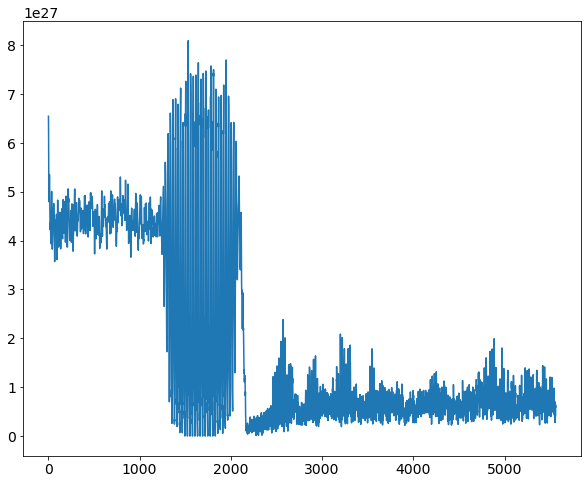

In [18]:
plt.plot(d1)

In [19]:
omega = np.linspace(-omega_max/2, omega_max/2, len(ALL_FILES))

In [20]:
y = np.fft.fft(d1)
y = np.fft.fftshift(np.abs(y)/max(np.abs(y)))

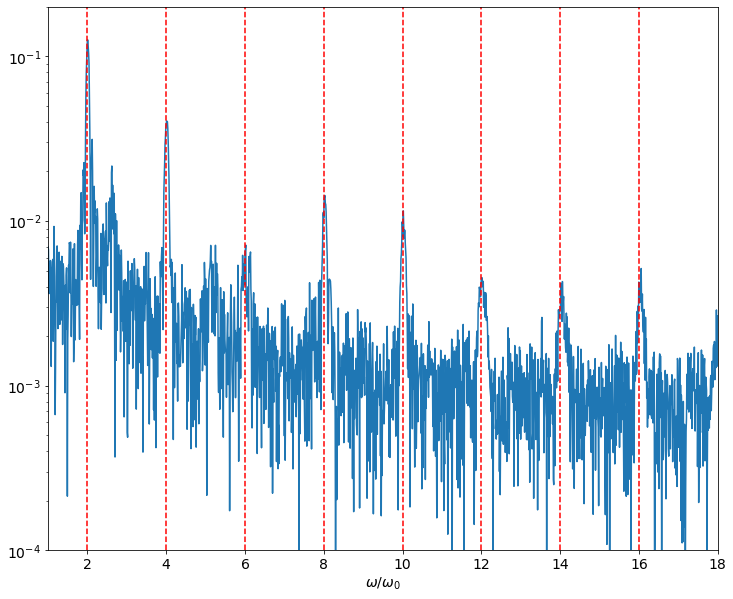

In [21]:
plt.figure(figsize=(12,10))
plt.plot(omega/omega0, y)
plt.yscale("log")
plt.xlim(1,18)
for i in np.arange(2,18,2):
    plt.axvline(i, color = "red", ls = "--")
plt.xlabel("$\omega/\omega_0$")
plt.ylim(0.0001, 0.2);